# Survival Analysis of Full Cohort 

This notebook analyzes median overall survival and hazard ratios among two clusters of patients based on clustering done in the file clustering analysis (using clusters 24 and 8 with small minimum cluster size).

In [26]:
import numpy as np
import pandas as pd

from flatiron_cleaner import DataProcessorUrothelial

from iptw_survival import IPTWSurvivalEstimator

import matplotlib.pyplot as plt

## Process mortality data 

In [27]:
cohort = pd.read_csv('../outputs/full_cohort.csv')

In [28]:
cohort.sample(3)

,PatientID,LineName,StartDate
3153,FF9351E915BD8,chemo,2022-07-12
609,FEAA8B216CA54,Pembrolizumab,2022-06-27
3617,FCFF5642EDEB5,chemo,2022-05-03


In [29]:
cohort.shape

(6461, 3)

In [30]:
processor = DataProcessorUrothelial()

# Process Enhanced_Mortality_V2.csv and use visit, telemedicine, biomarkers, oral, and progression data to determine censoring date 
mortality_df = processor.process_mortality(file_path = '../data/Enhanced_Mortality_V2.csv',
                                           index_date_df = cohort, 
                                           index_date_column = 'StartDate',
                                           visit_path = '../data/Visit.csv', 
                                           telemedicine_path = '../data/Telemedicine.csv', 
                                           biomarkers_path = '../data/Enhanced_AdvUrothelialBiomarkers.csv', 
                                           oral_path = '../data/Enhanced_AdvUrothelial_Orals.csv',
                                           progression_path = '../data/Enhanced_AdvUrothelial_Progression.csv',
                                           drop_dates = False)

2025-05-08 09:33:39,745 - INFO - Successfully read Enhanced_Mortality_V2.csv file with shape: (9040, 2) and unique PatientIDs: 9040
2025-05-08 09:33:39,785 - INFO - Successfully merged Enhanced_Mortality_V2.csv df with index_date_df resulting in shape: (6461, 3) and unique PatientIDs: 6461
2025-05-08 09:33:40,195 - INFO - The following columns ['last_visit_date', 'last_biomarker_date', 'last_oral_date', 'last_progression_date'] are used to calculate the last EHR date
2025-05-08 09:33:40,203 - INFO - Successfully processed Enhanced_Mortality_V2.csv file with final shape: (6461, 6) and unique PatientIDs: 6461. There are 0 out of 6461 patients with missing duration values


In [31]:
mortality_df.head(3)

,PatientID,imported_StartDate,DateOfDeath,event,last_ehr_activity,duration
0,F5AAF96C85477,2021-07-08,NaT,0,2021-09-14,68.0
1,F788831A66E9A,2023-02-22,NaT,0,2023-05-11,78.0
2,F75847DF35E43,2019-04-25,2019-06-15,1,2019-05-28,51.0


In [32]:
mortality_df.shape

(6461, 6)

In [33]:
mortality_df = pd.merge(mortality_df, cohort[['PatientID', 'LineName']], on = 'PatientID', how = 'left')

In [34]:
mortality_df.shape

(6461, 7)

In [35]:
mortality_df.sample(3)

,PatientID,imported_StartDate,DateOfDeath,event,last_ehr_activity,duration,LineName
4553,F7034582FC9EA,2015-11-09,2016-11-15,1,2015-12-14,372.0,chemo
4901,FA013D2EBD968,2021-09-15,2022-05-15,1,2022-04-19,242.0,chemo
991,F7F92897558B0,2019-01-08,2019-02-15,1,2019-01-28,38.0,Pembrolizumab


In [36]:
mortality_df.rename(columns={'imported_StartDate': 'StartDate'}, inplace=True)

In [37]:
mortality_df['treatment'] = ((mortality_df['LineName'] == 'Pembrolizumab') | (mortality_df['LineName'] == 'Atezolizumab')).astype(int)

In [38]:
mortality_df.sample(3)

,PatientID,StartDate,DateOfDeath,event,last_ehr_activity,duration,LineName,treatment
631,FBE52A1C86D48,2021-06-03,2022-08-15,1,2022-08-10,438.0,Pembrolizumab,1
4076,FE5FAE050F2B3,2023-02-08,2023-06-15,1,2023-02-09,127.0,chemo,0
5875,FF0AF895180A3,2011-07-29,2012-08-15,1,2012-09-17,383.0,chemo,0


In [82]:
mortality_df = mortality_df.query('duration >= 0')

In [83]:
mortality_df.shape

(6446, 8)

## Merge cleaned data from data_cleaning_auto.ipynb

In [102]:
dtype_map = pd.read_csv('../outputs/final_df_dtypes.csv', index_col = 0).iloc[:, 0].to_dict()
df = pd.read_csv('../outputs/final_df.csv', dtype = dtype_map)

In [103]:
df.head(3)

,PatientID,DiseaseGrade,SmokingStatus,Surgery,GroupStage_mod,TStage_mod,NStage_mod,MStage_mod,SurgeryType_mod,days_diagnosis_to_adv,...,drug_abuse,psychoses,depression,van_walraven_score,lymph_met,thoracic_met,liver_met,bone_met,other_gi_met,other_combined_met
0,F0016E985D839,High grade (G2/G3/G4),1,1,IV,T3,N1,M0,upper,0.0,...,0,0,0,4,0,0,0,0,0,0
1,F001E5D4C6FA0,Low grade (G1),1,1,unknown,T1,unknown,unknown,bladder,274.0,...,0,0,0,<NA>,0,0,0,0,0,0
2,F0025BA658AE1,High grade (G2/G3/G4),1,0,unknown,T3,unknown,M0,NaN,621.0,...,0,0,0,4,0,0,0,0,0,0


In [104]:
df.shape

(6461, 149)

In [105]:
df = pd.merge(mortality_df[['PatientID' , 'event', 'duration', 'treatment']], df, on = 'PatientID', how = 'left')

In [106]:
df.shape

(6446, 152)

## Merge insurance and SES information from insurance_ses.ipynb

In [107]:
insurance_ses_df = pd.read_csv('../outputs/insurance_ses_df.csv')

In [108]:
insurance_ses_df.head(3)

,PatientID,commercial,medicaid,medicare,other_insurance,ses_mod
0,F5AAF96C85477,0,0,1,0,1 - Lowest SES
1,F788831A66E9A,1,0,1,0,1 - Lowest SES
2,F75847DF35E43,1,0,0,1,2-4


In [109]:
insurance_ses_df.shape

(6461, 6)

In [110]:
insurance_ses_df['ses_mod'] = insurance_ses_df['ses_mod'].astype('category')

In [111]:
df = pd.merge(df, insurance_ses_df, on = 'PatientID', how = 'left')

In [112]:
df.shape

(6446, 157)

## Merge clusters

In [113]:
cluster_df = pd.read_csv('../outputs/df_with_clusters.csv')

In [114]:
cluster_df.sample(3)

,PatientID,PrimarySite_lower,SmokingStatus,Surgery,days_diagnosis_to_adv,age,ecog_newly_gte2,bmi_index,percent_change_weight,hypotension,...,neutrophil_min,lymphocyte,lymphocyte_max,lymphocyte_min,stage_0_III,stage_IV,pdl1,fgfr,ecog_2+,cluster
5467,FD8F634FD5576,0,0,1,0.0,76,0,22.373472,-0.347826,0,...,3.54,2.20,2.94,1.9,0,1,0,0,0,8
4515,FB30D4235D7BD,1,0,0,1258.0,79,0,22.384958,-5.253837,0,...,4.80,2.50,2.50,1.5,0,0,0,0,0,24
3470,F8B9DECA8D751,1,1,0,1366.0,85,0,22.911601,-18.495684,0,...,5.30,1.38,1.60,1.2,0,0,0,0,1,24


In [115]:
cluster_df.shape

(6461, 63)

In [116]:
df = pd.merge(df, cluster_df[['PatientID', 'cluster']], on = 'PatientID', how = 'left')

In [117]:
df.shape

(6446, 158)

In [118]:
df.sample(3)

,PatientID,event,duration,treatment,DiseaseGrade,SmokingStatus,Surgery,GroupStage_mod,TStage_mod,NStage_mod,...,liver_met,bone_met,other_gi_met,other_combined_met,commercial,medicaid,medicare,other_insurance,ses_mod,cluster
1859,F99E041365550,1,337.0,1,High grade (G2/G3/G4),1,1,0-II,T2,N0,...,0,0,0,0,1,0,0,1,unknown,24
300,FF35817F0884B,1,96.0,1,High grade (G2/G3/G4),0,0,unknown,T2,N0,...,0,0,0,1,1,1,0,1,2-4,24
4847,F0B64466B4294,0,315.0,0,High grade (G2/G3/G4),1,0,unknown,other,unknown,...,0,0,0,1,0,0,1,1,2-4,24


## Survival Analysis 
We will perform survival analysis in cluster 24 and cluster 8

In [120]:
cluster_8 = df[cluster_df['cluster'] == 8]

/var/folders/q7/3mfjt48n48v4fyx7k0bgxfk40000gn/T/ipykernel_18977/3294905742.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cluster_8 = df[cluster_df['cluster'] == 8]


In [121]:
cluster_8.shape

(2591, 158)

In [122]:
cluster_24 = df[cluster_df['cluster'] == 24]

/var/folders/q7/3mfjt48n48v4fyx7k0bgxfk40000gn/T/ipykernel_18977/4035994370.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cluster_24 = df[cluster_df['cluster'] == 24]


In [123]:
cluster_24.shape

(2736, 158)

## Preprocessing Cluster 8

In [124]:
(
    cluster_8.groupby('treatment')['event']
    .apply(lambda x: (x == 0).mean())
)

treatment
0    0.300650
1    0.317372
Name: event, dtype: float64

In [125]:
cluster_8['creatinine_2'] = np.where(cluster_8['creatinine'] > 2, 1, 0)

/var/folders/q7/3mfjt48n48v4fyx7k0bgxfk40000gn/T/ipykernel_18977/1857078971.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_8['creatinine_2'] = np.where(cluster_8['creatinine'] > 2, 1, 0)


In [126]:
cluster_8.groupby(['adv_diagnosis_year', 'treatment']).size().unstack(fill_value=0)

/var/folders/q7/3mfjt48n48v4fyx7k0bgxfk40000gn/T/ipykernel_18977/1108017196.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cluster_8.groupby(['adv_diagnosis_year', 'treatment']).size().unstack(fill_value=0)


treatment,0,1
adv_diagnosis_year,,
2011,76,0
2012,120,2
2013,131,2
2014,146,4
2015,178,12
2016,163,47
2017,153,123
2018,120,131
2019,128,160


In [127]:
cluster_8['adv_diagnosis_year'] = cluster_8['adv_diagnosis_year'].astype(int)

/var/folders/q7/3mfjt48n48v4fyx7k0bgxfk40000gn/T/ipykernel_18977/3052358404.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_8['adv_diagnosis_year'] = cluster_8['adv_diagnosis_year'].astype(int)


In [128]:
cluster_8['before_2020'] = np.where(cluster_8['adv_diagnosis_year'] < 2020, 1, 0)

/var/folders/q7/3mfjt48n48v4fyx7k0bgxfk40000gn/T/ipykernel_18977/1312102784.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_8['before_2020'] = np.where(cluster_8['adv_diagnosis_year'] < 2020, 1, 0)


### IPTW Cluster 8

In [129]:
estimator = IPTWSurvivalEstimator()

In [130]:
# We apply stabilized IPTW and clip propensity scores to the [0.01, 0.99] range to reduce the influence of extreme values
estimator.fit(df = cluster_8,
              treatment_col = 'treatment',
              cat_var = ['GroupStage_mod', 'ecog_index', 'ses_mod', 'PDL1_status'],
              cont_var = ['days_diagnosis_to_adv', 'age', 'weight_index', 'percent_change_weight', 'albumin', 'total_bilirubin', 'van_walraven_score'],
              binary_var = ['Surgery', 'opioid', 'commercial', 'medicaid', 'creatinine_2', 'before_2020'],
              lr_kwargs = {
                  'class_weight': 'balanced',
                  'solver': 'lbfgs',
                  'penalty': 'l2',
                  'max_iter': 1000,
                  'random_state': 42
              },
              clip_bounds = (0.01, 0.99),
              stabilized = True,)

In [131]:
iptw_df = estimator.transform()

In [132]:
ps_fig = estimator.propensity_score_plot(bins = 30)

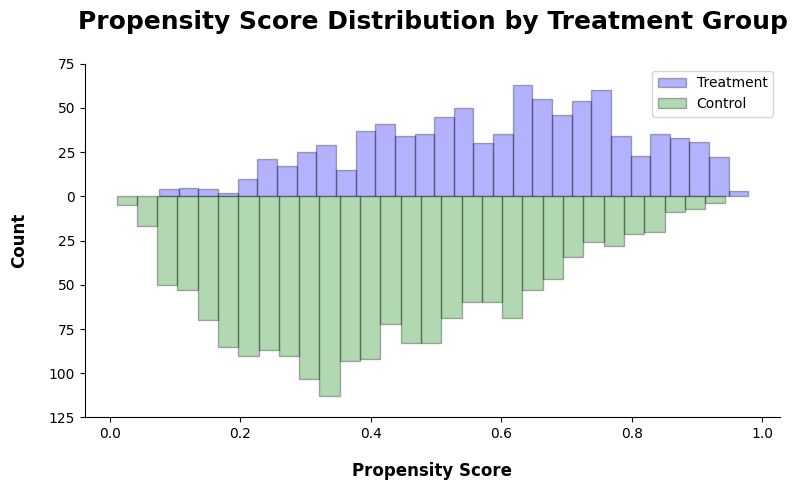

In [133]:
ps_fig

In [134]:
smd_df, smd_fig = estimator.standardized_mean_differences(return_fig = True)

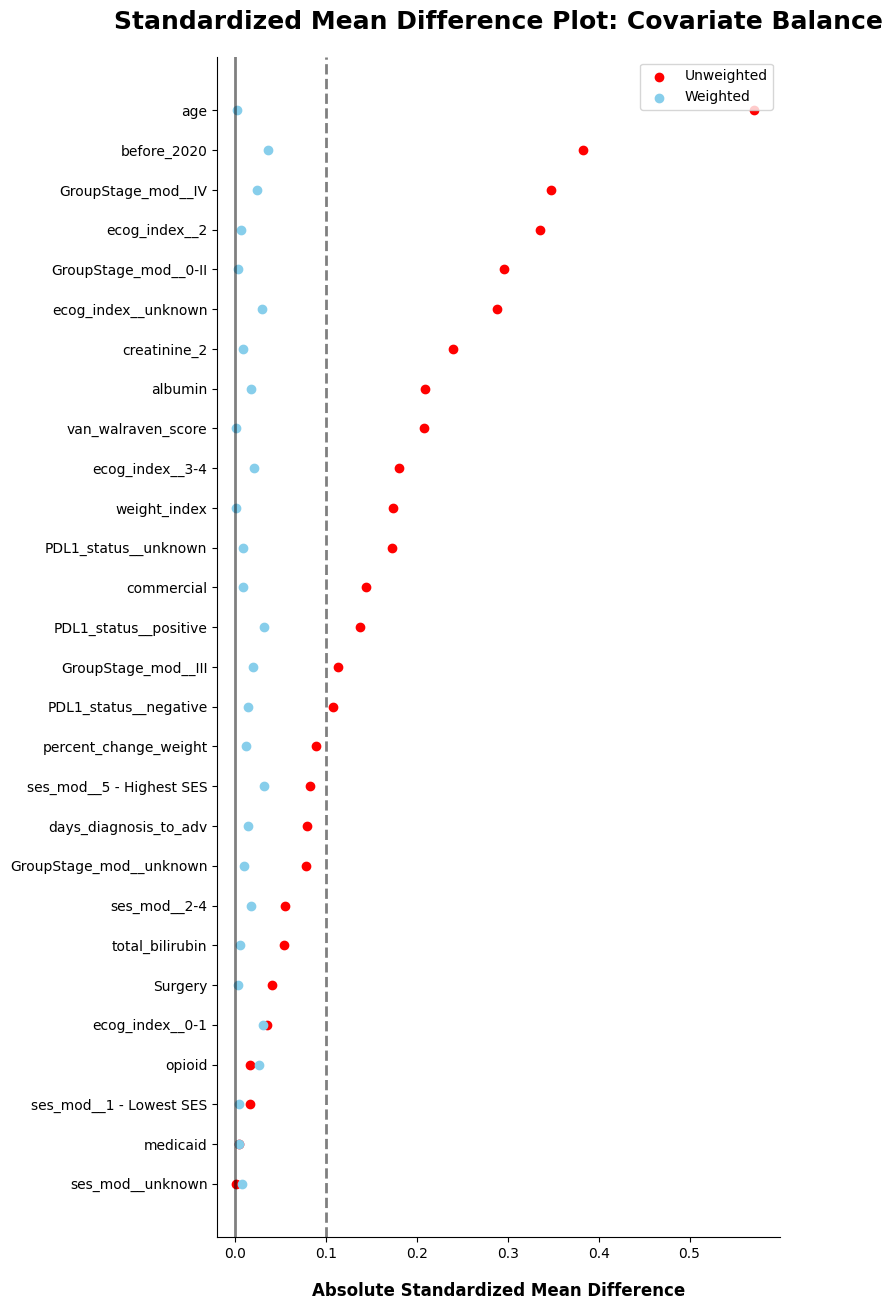

In [135]:
smd_fig

In [136]:
# Convert days to month
iptw_df['duration'] = iptw_df['duration']/30

In [137]:
km_confidence_intervals_df = estimator.km_confidence_intervals(df = iptw_df,
                                                               duration_col = 'duration',
                                                               event_col = 'event',
                                                               weight_col = 'iptw',
                                                               n_bootstrap = 1000,
                                                               random_state = 42)

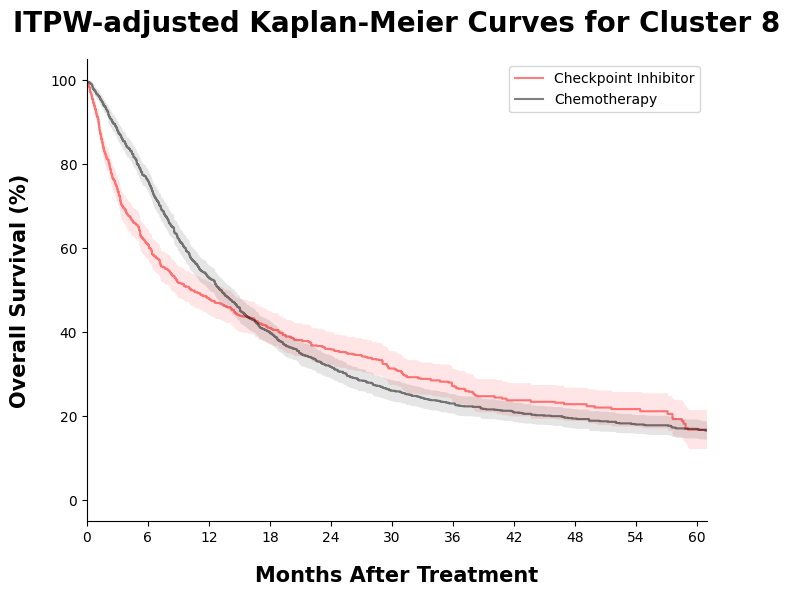

In [140]:
fig = plt.figure(figsize=(8, 6))

# ICI arm
# Estimate
plt.step(km_confidence_intervals_df.time, 
         km_confidence_intervals_df.treatment_estimate * 100, 
         color = 'red', 
         alpha = 0.5,
         label = 'Checkpoint Inhibitor')

# 95% CI
plt.fill_between(km_confidence_intervals_df.time, 
                 km_confidence_intervals_df.treatment_lower_ci * 100, 
                 km_confidence_intervals_df.treatment_upper_ci * 100, 
                 facecolor = 'red', 
                 alpha = 0.1)

# Chemotherapy arm
# Estimate
plt.step(km_confidence_intervals_df.time, 
         km_confidence_intervals_df.control_estimate * 100, 
         color = 'black', 
         alpha = 0.5,
         label = 'Chemotherapy')

# 95% CI
plt.fill_between(km_confidence_intervals_df.time, 
                 km_confidence_intervals_df.control_lower_ci * 100, 
                 km_confidence_intervals_df.control_upper_ci * 100, 
                 facecolor = 'black', 
                 alpha = 0.1)

plt.xticks(np.arange(0, 61, 6))
plt.xlim(0, 61)

plt.title('ITPW-adjusted Kaplan-Meier Curves for Cluster 8', size = 20, weight = 'bold',  pad = 20)
plt.ylabel('Overall Survival (%)', size = 15, weight = 'bold', labelpad = 15)
plt.xlabel('Months After Treatment', size = 15, weight = 'bold', labelpad = 15)
plt.legend(prop = {'size': 10})

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.savefig("../outputs/cluster_8_km_curve.png", dpi=300, bbox_inches='tight')

## Preprocessing Cluster 24

In [141]:
(
    cluster_24.groupby('treatment')['event']
    .apply(lambda x: (x == 0).mean())
)

treatment
0    0.315008
1    0.278081
Name: event, dtype: float64

In [142]:
cluster_24['creatinine_2'] = np.where(cluster_24['creatinine'] > 2, 1, 0)

/var/folders/q7/3mfjt48n48v4fyx7k0bgxfk40000gn/T/ipykernel_18977/3970165955.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_24['creatinine_2'] = np.where(cluster_24['creatinine'] > 2, 1, 0)


In [143]:
cluster_24.groupby(['adv_diagnosis_year', 'treatment']).size().unstack(fill_value=0)

/var/folders/q7/3mfjt48n48v4fyx7k0bgxfk40000gn/T/ipykernel_18977/1482702679.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cluster_24.groupby(['adv_diagnosis_year', 'treatment']).size().unstack(fill_value=0)


treatment,0,1
adv_diagnosis_year,,
2011,86,2
2012,118,1
2013,126,2
2014,150,0
2015,189,13
2016,189,60
2017,138,111
2018,131,156
2019,153,148


In [144]:
cluster_24['adv_diagnosis_year'] = cluster_24['adv_diagnosis_year'].astype(int)

/var/folders/q7/3mfjt48n48v4fyx7k0bgxfk40000gn/T/ipykernel_18977/584641370.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_24['adv_diagnosis_year'] = cluster_24['adv_diagnosis_year'].astype(int)


In [145]:
cluster_24['before_2020'] = np.where(cluster_24['adv_diagnosis_year'] < 2020, 1, 0)

/var/folders/q7/3mfjt48n48v4fyx7k0bgxfk40000gn/T/ipykernel_18977/4122447167.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_24['before_2020'] = np.where(cluster_24['adv_diagnosis_year'] < 2020, 1, 0)


## IPTW Cluster 24

In [147]:
estimator = IPTWSurvivalEstimator()

In [148]:
# We apply stabilized IPTW and clip propensity scores to the [0.01, 0.99] range to reduce the influence of extreme values
estimator.fit(df = cluster_24,
              treatment_col = 'treatment',
              cat_var = ['GroupStage_mod', 'ecog_index', 'ses_mod', 'PDL1_status'],
              cont_var = ['days_diagnosis_to_adv', 'age', 'weight_index', 'percent_change_weight', 'albumin', 'total_bilirubin', 'van_walraven_score'],
              binary_var = ['Surgery', 'opioid', 'commercial', 'medicaid', 'creatinine_2', 'before_2020'],
              lr_kwargs = {
                  'class_weight': 'balanced',
                  'solver': 'lbfgs',
                  'penalty': 'l2',
                  'max_iter': 1000,
                  'random_state': 42
              },
              clip_bounds = (0.01, 0.99),
              stabilized = True,)

In [149]:
iptw_df = estimator.transform()

In [150]:
ps_fig = estimator.propensity_score_plot(bins = 30)

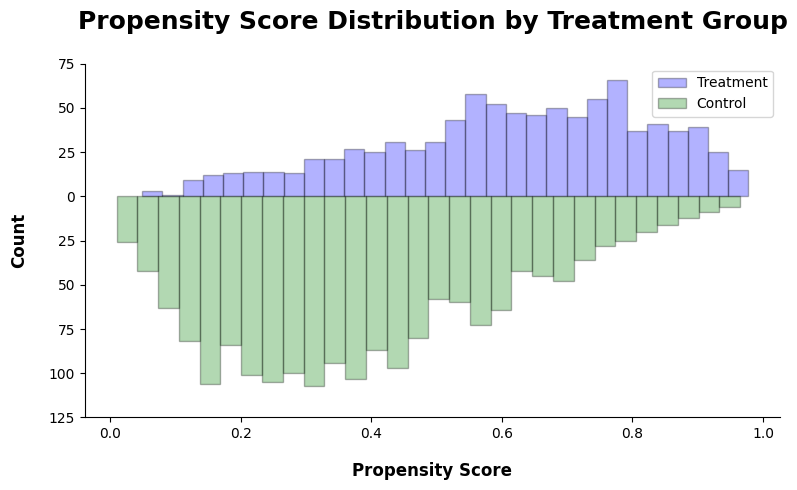

In [151]:
ps_fig

In [152]:
smd_df, smd_fig = estimator.standardized_mean_differences(return_fig = True)

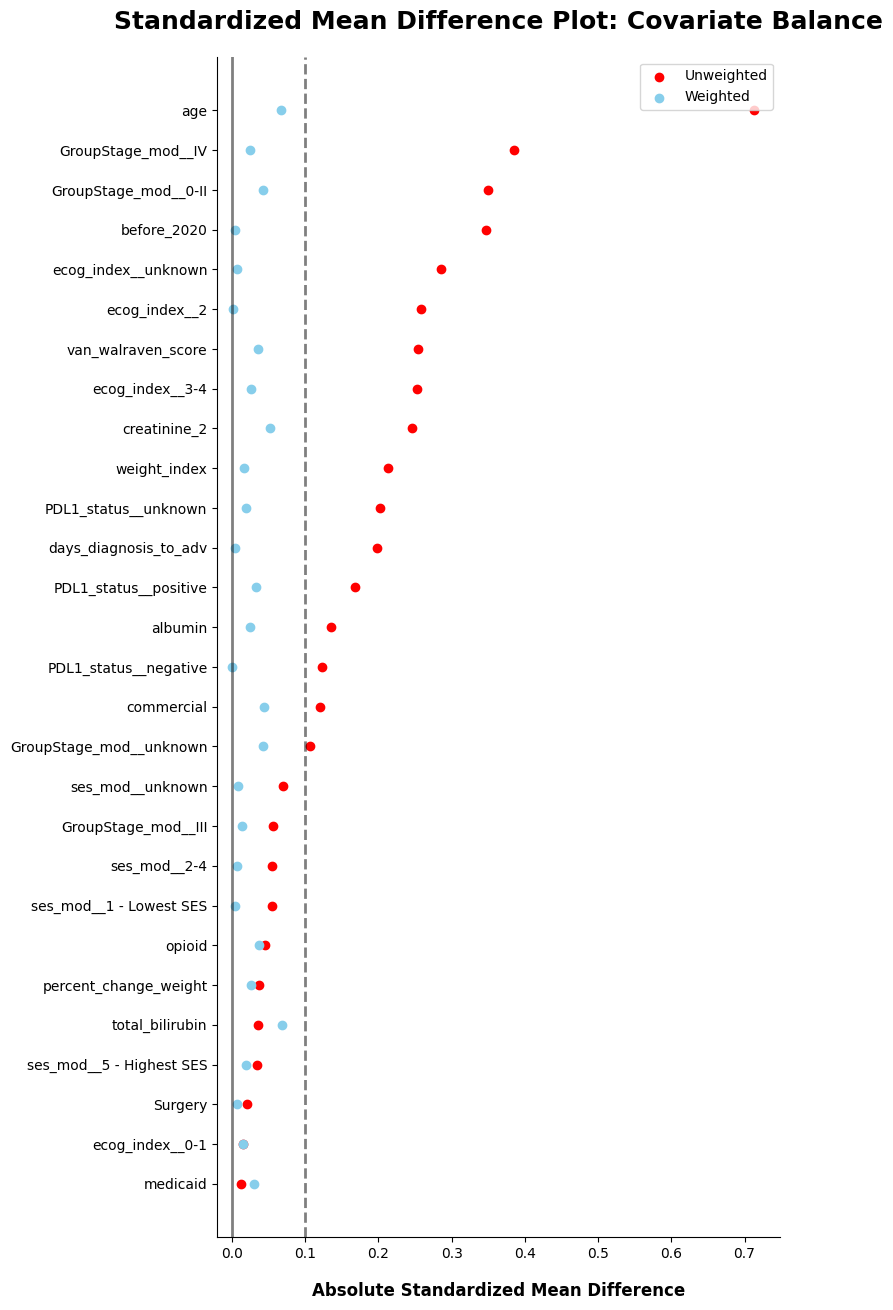

In [153]:
smd_fig

In [154]:
# Convert days to month
iptw_df['duration'] = iptw_df['duration']/30

In [155]:
km_confidence_intervals_df = estimator.km_confidence_intervals(df = iptw_df,
                                                               duration_col = 'duration',
                                                               event_col = 'event',
                                                               weight_col = 'iptw',
                                                               n_bootstrap = 1000,
                                                               random_state = 42)

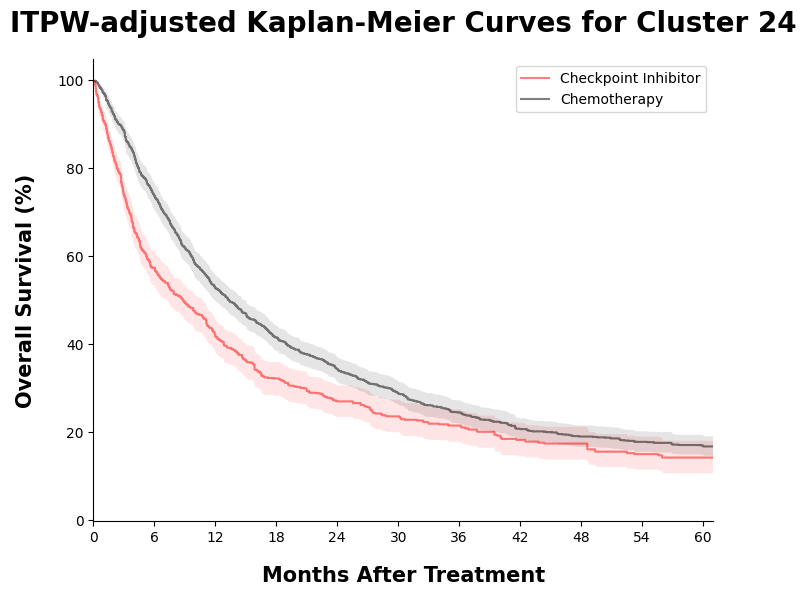

In [156]:
fig = plt.figure(figsize=(8, 6))

# ICI arm
# Estimate
plt.step(km_confidence_intervals_df.time, 
         km_confidence_intervals_df.treatment_estimate * 100, 
         color = 'red', 
         alpha = 0.5,
         label = 'Checkpoint Inhibitor')

# 95% CI
plt.fill_between(km_confidence_intervals_df.time, 
                 km_confidence_intervals_df.treatment_lower_ci * 100, 
                 km_confidence_intervals_df.treatment_upper_ci * 100, 
                 facecolor = 'red', 
                 alpha = 0.1)

# Chemotherapy arm
# Estimate
plt.step(km_confidence_intervals_df.time, 
         km_confidence_intervals_df.control_estimate * 100, 
         color = 'black', 
         alpha = 0.5,
         label = 'Chemotherapy')

# 95% CI
plt.fill_between(km_confidence_intervals_df.time, 
                 km_confidence_intervals_df.control_lower_ci * 100, 
                 km_confidence_intervals_df.control_upper_ci * 100, 
                 facecolor = 'black', 
                 alpha = 0.1)

plt.xticks(np.arange(0, 61, 6))
plt.xlim(0, 61)

plt.title('ITPW-adjusted Kaplan-Meier Curves for Cluster 24', size = 20, weight = 'bold',  pad = 20)
plt.ylabel('Overall Survival (%)', size = 15, weight = 'bold', labelpad = 15)
plt.xlabel('Months After Treatment', size = 15, weight = 'bold', labelpad = 15)
plt.legend(prop = {'size': 10})

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.savefig("../outputs/cluster_24_km_curve.png", dpi=300, bbox_inches='tight')